In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ten_stocks = pd.read_csv('Top 10 stocks.csv')

In [8]:
pool = ["600094.XSHG",    
        "600160.XSHG", 
        "600008.XSHG",
        "600903.XSHG",
        "000959.XSHE",
        "600970.XSHG",
        "002302.XSHE",
        "600823.XSHG",
        "002503.XSHE",
        "600664.XSHG"]

## Ljung Box Test and Dicket Fuller Test of price

In [17]:
import statsmodels.api as sm

# adfuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput['p-value']  # p<0.05, Stationary

results = pd.DataFrame(columns=['stock', 'ljung_p', 'dickey-fuller_p'])
for stock_name in pool:
    result = {'stock': stock_name, 'ljung_p': sm.stats.acorr_ljungbox(ten_stocks[stock_name].dropna(), lags=[12], return_df=True)['lb_pvalue'].values[0]
             , 'dickey-fuller_p': test_stationarity(ten_stocks[stock_name].dropna())}
    results = results.append(result, ignore_index=True) 
results

,stock,ljung_p,dickey-fuller_p
0,600094.XSHG,0.0,0.334249
1,600160.XSHG,0.0,0.048635
2,600008.XSHG,0.0,0.472087
3,600903.XSHG,0.0,0.021191
4,000959.XSHE,0.0,0.469813
5,600970.XSHG,0.0,0.389710
6,002302.XSHE,0.0,0.127531
7,600823.XSHG,0.0,0.584950
8,002503.XSHE,0.0,0.483810
9,600664.XSHG,0.0,0.833605


## Price plot

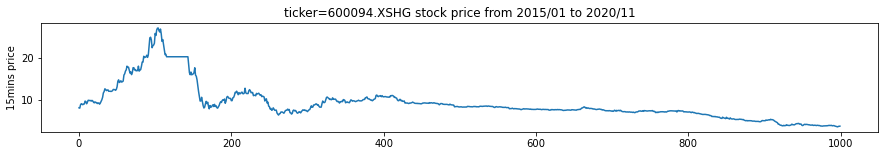

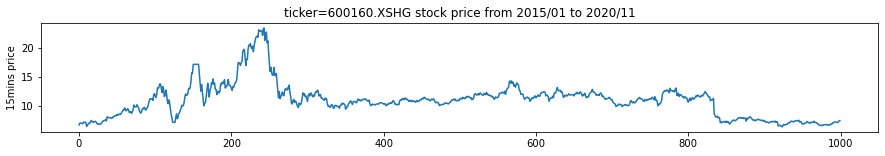

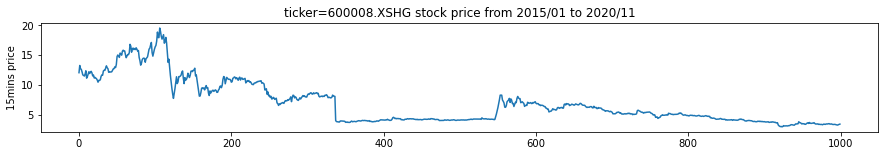

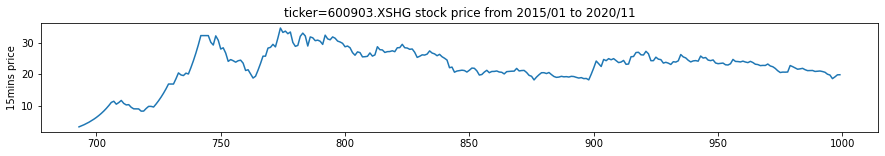

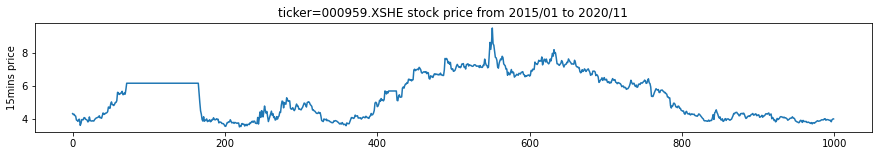

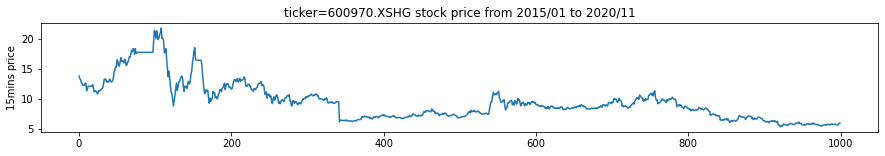

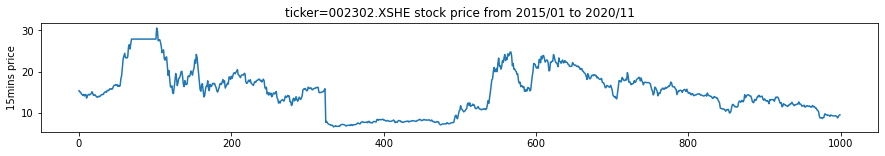

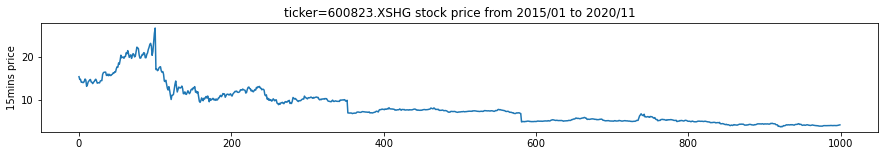

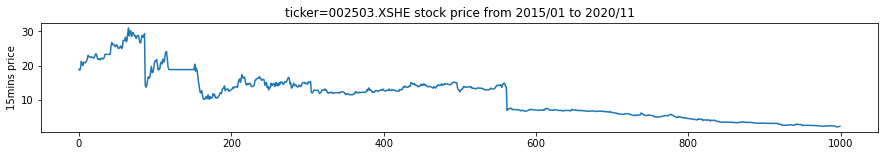

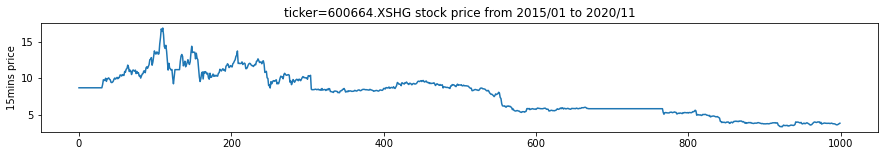

In [29]:
for stock_name in pool:
    ten_stocks[stock_name].dropna().plot(figsize=(15,2))
    plt.ylabel('15mins price')
    plt.title('ticker='+stock_name+' stock price from 2015/01 to 2020/11')
    plt.show()

## Log return plot + ACF/PACF

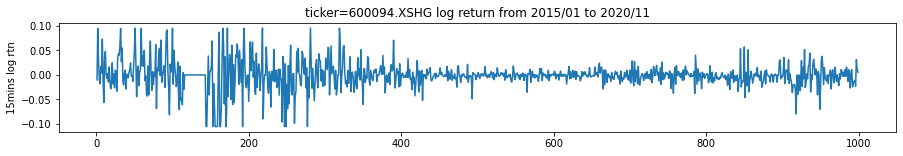

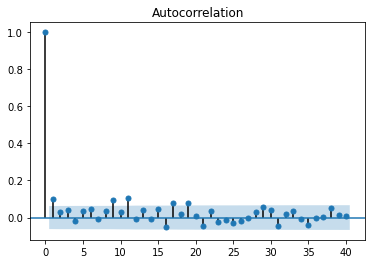

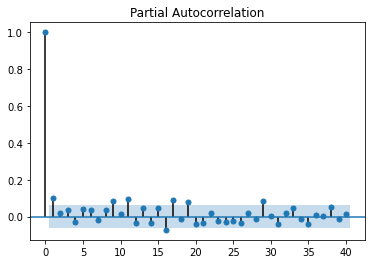

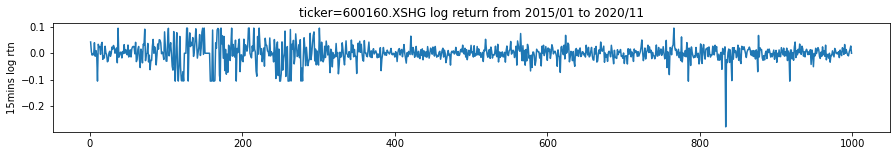

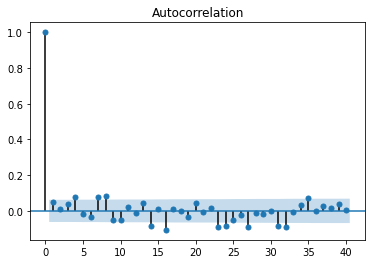

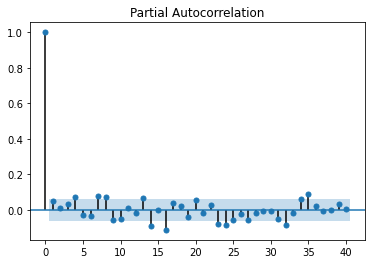

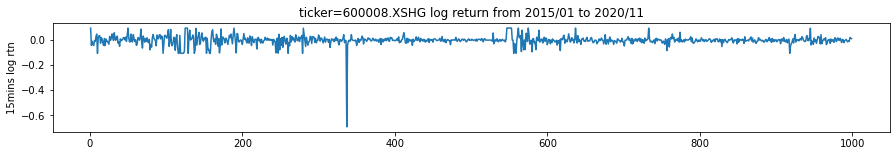

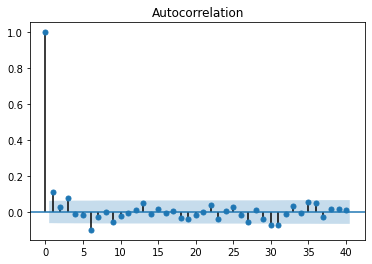

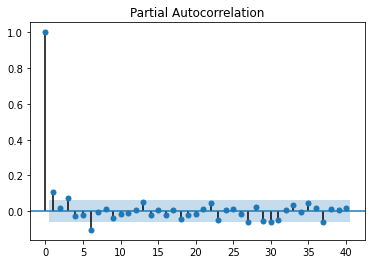

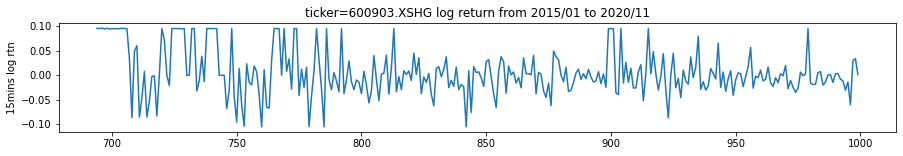

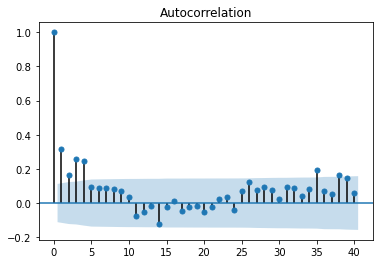

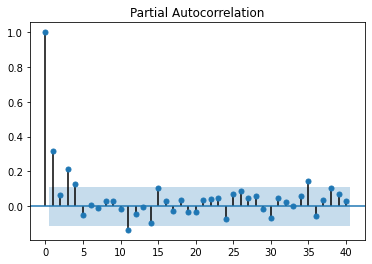

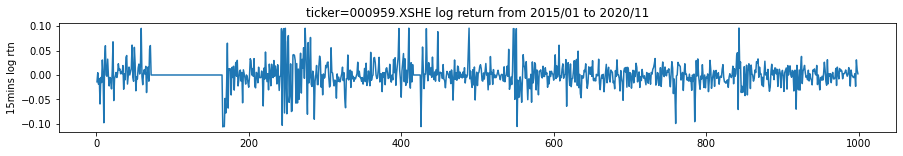

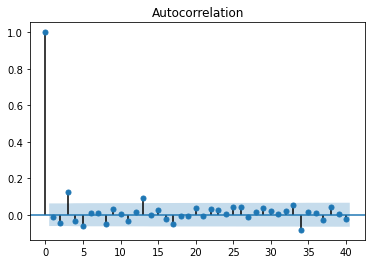

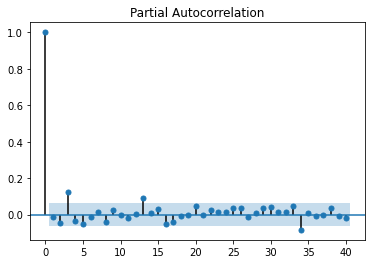

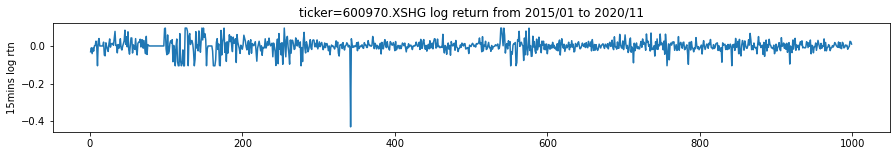

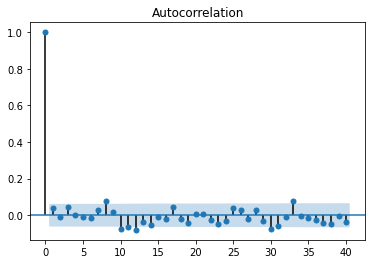

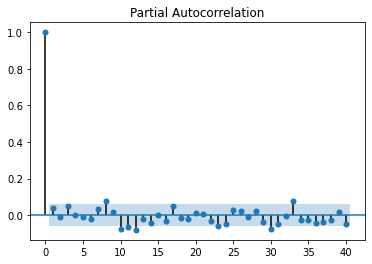

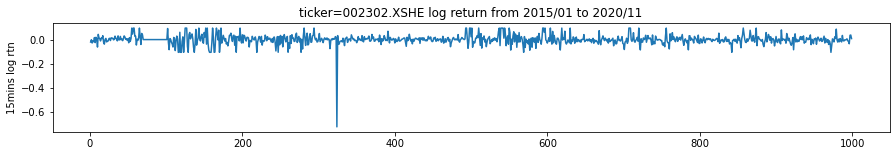

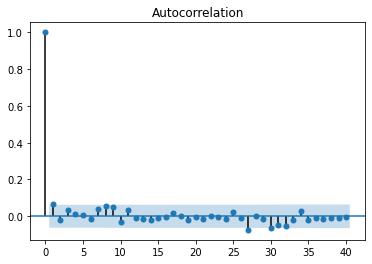

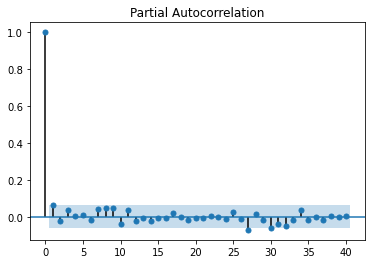

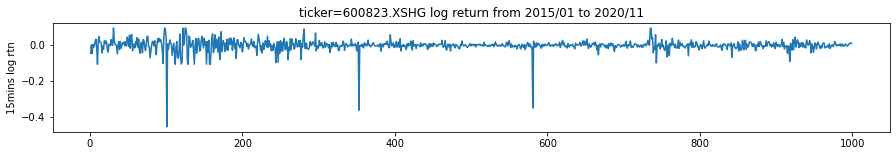

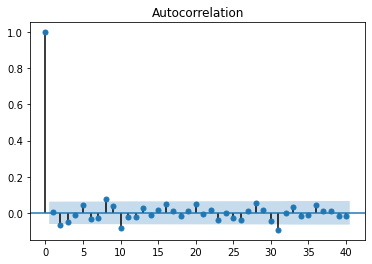

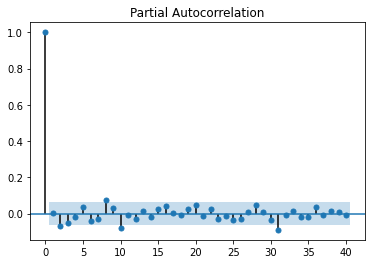

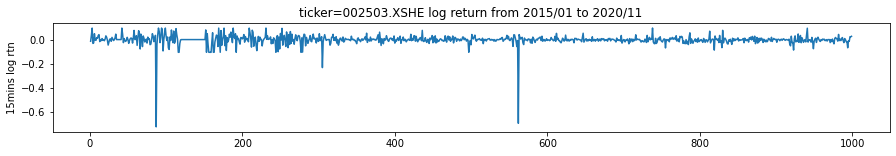

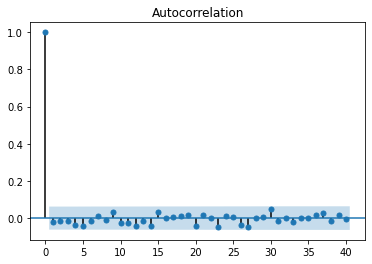

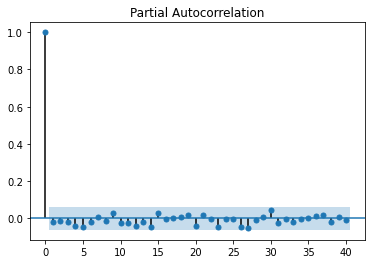

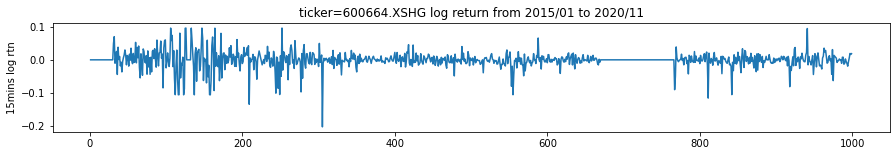

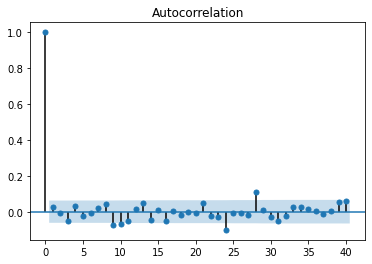

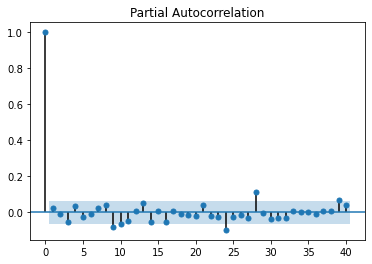

In [45]:
log_rtn_ten = {}
for stock_name in pool:
    log_rtn = np.log(ten_stocks[stock_name]).diff(1).dropna()
    log_rtn_ten[stock_name] = log_rtn
    log_rtn.plot(figsize=(15,2))
    plt.ylabel('15mins log rtn')
    plt.title('ticker='+stock_name+' log return from 2015/01 to 2020/11')
    plt.show()
    sm.graphics.tsa.plot_acf(log_rtn, lags=40) 
    plt.show()
    sm.graphics.tsa.plot_pacf(log_rtn, lags=40)
    plt.show()

## ARMA

In [36]:
import pandas as pd
import itertools
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima_model import ARIMA

p = range(5)
q = range(5)

combinations = list(itertools.product(p, q))
combinations = combinations[1:] # Drop (0,0)

results = pd.DataFrame(columns=['stock_name', 'p', 'q', 'ljung_p', 'aic'])

def train_ARMA(param):
    global results
    try:
        p = param[0]
        q = param[1]
        
        for stock_name, log_rtn in log_rtn_ten.items():
            model = ARIMA(log_rtn, order=(p,0,q))

            model_fit = model.fit(disp=0)

            ljung_p = sm.stats.acorr_ljungbox(model_fit.resid, lags=[12], return_df=True).values[0][1]
            aic = model_fit.aic
            results = results.append({'stock_name': stock_name, 'p': p, 'q': q, 'ljung_p': ljung_p, 'aic': aic}, ignore_index=True)
    except:
        print('Cannot fit param: '+str(param))


for pq in combinations:
    train_ARMA(pq)

results

Cannot fit param: (1, 2)
Cannot fit param: (1, 3)
Cannot fit param: (1, 4)
Cannot fit param: (2, 3)
Cannot fit param: (2, 4)
Cannot fit param: (3, 4)


,stock_name,p,q,ljung_p,aic
0,600094.XSHG,0,1,0.005804,-4360.495894
1,600160.XSHG,0,1,0.006102,-3885.886440
2,600008.XSHG,0,1,0.061556,-3712.660929
3,600903.XSHG,0,1,0.000900,-1024.793151
4,000959.XSHE,0,1,0.006838,-4476.632160
...,...,...,...,...,...
175,600970.XSHG,4,4,0.290797,-3870.618069
176,002302.XSHE,4,4,0.921467,-3468.198341
177,600823.XSHG,4,4,0.828851,-3996.850963
178,002503.XSHE,4,4,0.956447,-3423.157858


### Get the best fitted model

In [44]:
results.loc[results[results['ljung_p']>=0.05].groupby(by=["stock_name"])['aic'].idxmin()]

,stock_name,p,q,ljung_p,aic
114,000959.XSHE,3,2,0.989193,-4490.184557
56,002302.XSHE,1,1,0.633859,-3473.050921
58,002503.XSHE,1,1,0.951853,-3431.912317
22,600008.XSHG,0,3,0.477798,-3717.324996
80,600094.XSHG,2,2,0.134810,-4371.331600
121,600160.XSHG,3,3,0.239196,-3909.989194
9,600664.XSHG,0,1,0.057513,-4484.260441
117,600823.XSHG,3,2,0.485386,-4001.851461
133,600903.XSHG,4,0,0.835318,-1044.795329
125,600970.XSHG,3,3,0.386109,-3876.522553


## GARCH

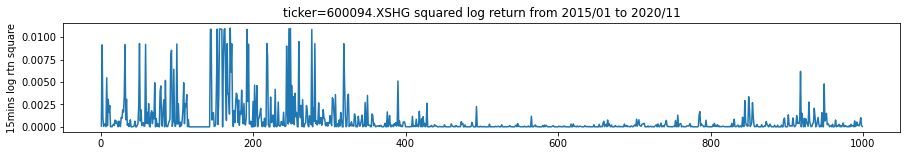

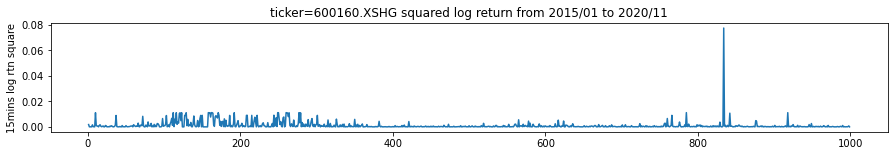

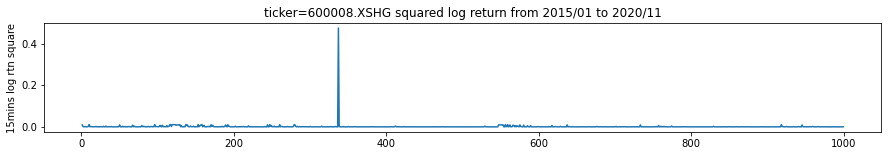

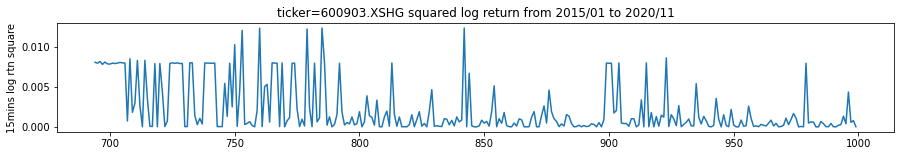

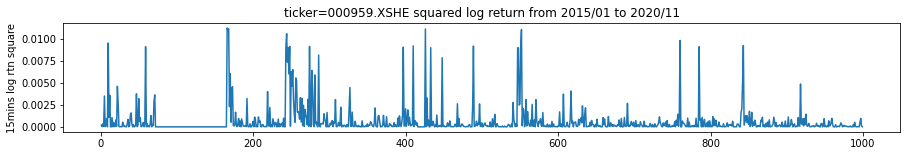

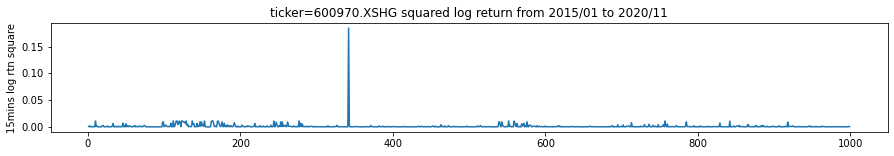

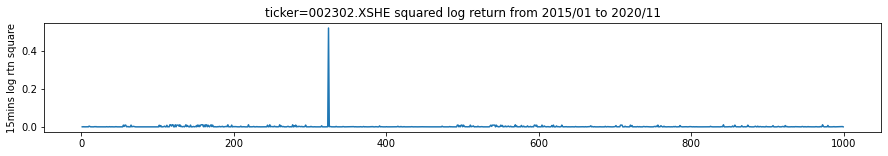

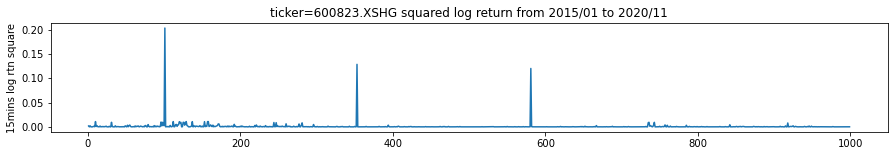

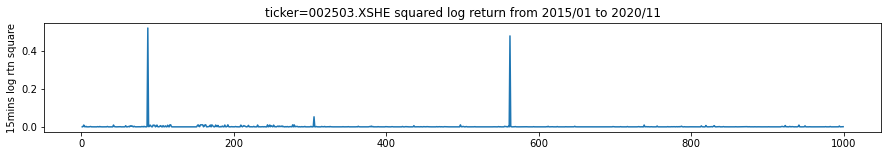

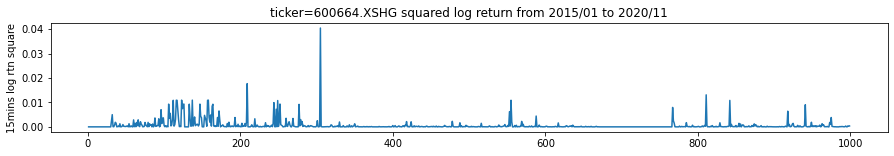

In [48]:
log_rtn_square_ten = {}
for stock_name in pool:
    log_rtn = np.log(ten_stocks[stock_name]).diff(1).dropna()
    log_rtn_square = np.square(log_rtn - log_rtn.mean())
    log_rtn_square_ten[stock_name] = log_rtn_square
    log_rtn_square.plot(figsize=(15,2))
    plt.ylabel('15mins log rtn square')
    plt.title('ticker='+stock_name+' squared log return from 2015/01 to 2020/11')
    plt.show()

In [55]:
import statsmodels.api as sm

results = pd.DataFrame(columns=['stock_name', 'ljung_p'])

for stock_name in pool:
    p_2 = sm.stats.acorr_ljungbox(log_rtn_square_ten[stock_name], lags=[40], return_df=True)['lb_pvalue'].values[0]
    result = {'stock_name': stock_name, 'ljung_p': p_2}
    results = results.append(result, ignore_index=True)
    
results[results['ljung_p']<0.05]

,stock_name,ljung_p
0,600094.XSHG,1.407775e-308
1,600160.XSHG,3.158936e-59
3,600903.XSHG,6.069005e-89
4,000959.XSHE,1.474008e-63
9,600664.XSHG,1.330901e-71


In [59]:
stocks_with_ARCH = results[results['ljung_p']<0.05]['stock_name'].values

In [71]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,5)
q = range(1,5)

combinations = list(itertools.product(p, q))
results = pd.DataFrame(columns=['p', 'q', 'params', 'ljung_p', 'aic'])

def train_GARCH(param):
    global results
    p = param[0]
    q = param[1]
    
    
    for stock_name in stocks_with_ARCH:
        model = arch_model(log_rtn_ten[stock_name], mean='constant', p=p, q=q)
    
        res = model.fit(update_freq=0)
    
        ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
        aic = res.aic
        
        result = {'stock_name': stock_name, 'p':p, 'q': q, 'params': res.params, 'ljung_p': ljung_p, 'aic': aic}
        results = results.append(result, ignore_index=True)


for pq in combinations:
    train_GARCH(pq)

results.loc[results[results['ljung_p']>=0.05].groupby(by=["stock_name"])['aic'].idxmin()]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2471.1593143086047
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2081.105453066055
            Iterations: 14
            Function evaluations: 102
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -537.8488350738997
            Iterations: 18
            Function evaluations: 117
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2349.2801246170266
            Iterations: 2
            Function evaluations: 26
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2447.8370603941576
            Iterations: 16
            Function ev

,p,q,params,ljung_p,aic,stock_name
8,1,2,mu -0.000489 omega 0.000049 alph...,0.973494,-4713.739734,000959.XSHE
10,1,3,mu -1.109045e-03 omega 2.461710e...,0.224776,-5022.374495,600094.XSHG
46,3,2,mu 0.001211 omega 0.000036 alph...,0.241900,-4173.695811,600160.XSHG
29,2,2,mu -1.150754e-03 omega 4.527845e...,0.970299,-4912.250697,600664.XSHG


## EGARCH

In [75]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,5)
q = range(1,5)

combinations = list(itertools.product(p, q))
results = pd.DataFrame(columns=['p', 'q', 'params', 'ljung_p', 'aic'])

def train_EGARCH(param):
    global results
    p = param[0]
    q = param[1]
    
    
    for stock_name in stocks_with_ARCH:
        try:
            model = arch_model(log_rtn_ten[stock_name], vol='EGARCH', mean='constant', p=p, q=q, dist='t')

            res = model.fit(update_freq=0)

            ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
            aic = res.aic

            result = {'stock_name': stock_name, 'p':p, 'q': q, 'params': res.params, 'ljung_p': ljung_p, 'aic': aic}
            results = results.append(result, ignore_index=True)
        except:
            continue


for pq in combinations:
    train_EGARCH(pq)

results.loc[results[results['ljung_p']>=0.05].groupby(by=["stock_name"])['aic'].idxmin()]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2608.063673463872
            Iterations: 32
            Function evaluations: 235
            Gradient evaluations: 32
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2172.7409672183107
            Iterations: 59
            Function evaluations: 435
            Gradient evaluations: 57
Optimization terminated successfully    (Exit mode 0)
            Current function value: -542.9491698130306
            Iterations: 47
            Function evaluations: 373
            Gradient evaluations: 45
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4609.15283824786
            Iterations: 30
            Function evaluations: 249
            Gradient evaluations: 29
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4284.017059078509
            Iterations: 3
            Function eval

/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Optimization terminated successfully    (Exit mode 0)
            Current function value: -2608.7732206389346
            Iterations: 29
            Function evaluations: 237
            Gradient evaluations: 29
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5580.54906030949
            Iterations: 71
            Function evaluations: 716
            Gradient evaluations: 68
Optimization terminated successfully    (Exit mode 0)
            Current function value: -543.2646286100671
            Iterations: 43
            Function evaluations: 344
            Gradient evaluations: 43
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4954.742876540538
            Iterations: 8
            Function evaluations: 95
            Gradient evaluations: 7


/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Optimization terminated successfully    (Exit mode 0)
            Current function value: -2608.9540570055533
            Iterations: 64
            Function evaluations: 567
            Gradient evaluations: 64
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2172.740966973997
            Iterations: 92
            Function evaluations: 834
            Gradient evaluations: 90
Optimization terminated successfully    (Exit mode 0)
            Current function value: -543.6720664379566
            Iterations: 43
            Function evaluations: 388
            Gradient evaluations: 43
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5971.8270461231
            Iterations: 52
            Function evaluations: 577
            Gradient evaluations: 50
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4328.729787764052
            Iterations: 5
            Function eval

/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Iteration limit reached    (Exit mode 9)
            Current function value: 5960.023175198564
            Iterations: 100
            Function evaluations: 1168
            Gradient evaluations: 96


/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Optimization terminated successfully    (Exit mode 0)
            Current function value: -2172.740967083834
            Iterations: 91
            Function evaluations: 920
            Gradient evaluations: 89
Optimization terminated successfully    (Exit mode 0)
            Current function value: -544.1451343857415
            Iterations: 64
            Function evaluations: 650
            Gradient evaluations: 63
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2601.67143623622
            Iterations: 85
            Function evaluations: 858
            Gradient evaluations: 84
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5142.9464299529045
            Iterations: 41
            Function evaluations: 459
            Gradient evaluations: 38


/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Optimization terminated successfully    (Exit mode 0)
            Current function value: -2608.865867484865
            Iterations: 41
            Function evaluations: 332
            Gradient evaluations: 41
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5028.249408952421
            Iterations: 11
            Function evaluations: 113
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -544.238998113529
            Iterations: 69
            Function evaluations: 550
            Gradient evaluations: 69
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2602.210003001158
            Iterations: 75
            Function evaluations: 600
            Gradient evaluations: 75
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2608.8405816961213
            Iterations: 27
            Function e

/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Optimization terminated successfully    (Exit mode 0)
            Current function value: -544.3196681689515
            Iterations: 35
            Function evaluations: 321
            Gradient evaluations: 35
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2602.008207297496
            Iterations: 86
            Function evaluations: 778
            Gradient evaluations: 86
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4131.5328283645595
            Iterations: 4
            Function evaluations: 60
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2608.986488164166
            Iterations: 26
            Function evaluations: 268
            Gradient evaluations: 26


/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Inequality constraints incompatible    (Exit mode 4)
            Current function value: 898.441707644284
            Iterations: 19
            Function evaluations: 226
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: -544.2389981254626
            Iterations: 50
            Function evaluations: 496
            Gradient evaluations: 50
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4828.312529365041
            Iterations: 16
            Function evaluations: 204
            Gradient evaluations: 15
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -530.7707880439234
            Iterations: 15
            Function evaluations: 171
            Gradient evaluations: 15


/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Optimization terminated successfully    (Exit mode 0)
            Current function value: -2609.3291020319366
            Iterations: 47
            Function evaluations: 514
            Gradient evaluations: 47
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2866.740195860719
            Iterations: 53
            Function evaluations: 626
            Gradient evaluations: 49
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 287.60518999938597
            Iterations: 19
            Function evaluations: 248
            Gradient evaluations: 18


/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Iteration limit reached    (Exit mode 9)
            Current function value: 7580.9318950641045
            Iterations: 100
            Function evaluations: 1252
            Gradient evaluations: 99
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2608.891465190367
            Iterations: 44
            Function evaluations: 397
            Gradient evaluations: 44


/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Optimization terminated successfully    (Exit mode 0)
            Current function value: -2173.540017188968
            Iterations: 68
            Function evaluations: 604
            Gradient evaluations: 68
Optimization terminated successfully    (Exit mode 0)
            Current function value: -545.4009471186545
            Iterations: 82
            Function evaluations: 733
            Gradient evaluations: 82
Iteration limit reached    (Exit mode 9)
            Current function value: 5447.382437077103
            Iterations: 100
            Function evaluations: 949
            Gradient evaluations: 98
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1434.2736652793972
            Iterations: 13
            Function evaluations: 135
            Gradient evaluations: 13


/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Optimization terminated successfully    (Exit mode 0)
            Current function value: -2609.093571466499
            Iterations: 30
            Function evaluations: 311
            Gradient evaluations: 30
Optimization terminated successfully    (Exit mode 0)
            Current function value: -544.8491047513487
            Iterations: 39
            Function evaluations: 392
            Gradient evaluations: 39
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2388.9948573648876
            Iterations: 37
            Function evaluations: 435
            Gradient evaluations: 37
Iteration limit reached    (Exit mode 9)
            Current function value: 2709.137340755637
            Iterations: 100
            Function evaluations: 995
            Gradient evaluations: 99
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2609.1561582333134
            Iterations: 43
            Function evaluation

/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 6205.862679018259
            Iterations: 95
            Function evaluations: 1192
            Gradient evaluations: 91


/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Optimization terminated successfully    (Exit mode 0)
            Current function value: -545.5370644281159
            Iterations: 68
            Function evaluations: 743
            Gradient evaluations: 68
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2603.0439547379824
            Iterations: 61
            Function evaluations: 666
            Gradient evaluations: 61
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3364.853420514826
            Iterations: 16
            Function evaluations: 198
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2610.312408809901
            Iterations: 50
            Function evaluations: 600
            Gradient evaluations: 50


/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Optimization terminated successfully    (Exit mode 0)
            Current function value: -2175.5871147548814
            Iterations: 91
            Function evaluations: 1093
            Gradient evaluations: 89
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 452.03425747280573
            Iterations: 14
            Function evaluations: 203
            Gradient evaluations: 13


/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Optimization terminated successfully    (Exit mode 0)
            Current function value: -2602.960775179403
            Iterations: 74
            Function evaluations: 872
            Gradient evaluations: 74
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3614.721206393345
            Iterations: 19
            Function evaluations: 261
            Gradient evaluations: 19


/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Optimization terminated successfully    (Exit mode 0)
            Current function value: -2608.8978730705367
            Iterations: 57
            Function evaluations: 585
            Gradient evaluations: 57
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2173.5441385474605
            Iterations: 62
            Function evaluations: 656
            Gradient evaluations: 61
Optimization terminated successfully    (Exit mode 0)
            Current function value: 220.2882696113071
            Iterations: 43
            Function evaluations: 505
            Gradient evaluations: 43
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4810.724341083247
            Iterations: 27
            Function evaluations: 318
            Gradient evaluations: 26
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3515.7952429761212
            Iterations: 5
            Function ev

/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Optimization terminated successfully    (Exit mode 0)
            Current function value: -2609.250126097162
            Iterations: 28
            Function evaluations: 321
            Gradient evaluations: 28
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 6309.442929859131
            Iterations: 51
            Function evaluations: 652
            Gradient evaluations: 47


/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Optimization terminated successfully    (Exit mode 0)
            Current function value: -2602.900610968041
            Iterations: 53
            Function evaluations: 600
            Gradient evaluations: 53
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5367.074654533397
            Iterations: 7
            Function evaluations: 86
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2609.631842789352
            Iterations: 33
            Function evaluations: 405
            Gradient evaluations: 33


/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Iteration limit reached    (Exit mode 9)
            Current function value: -2175.8377826015007
            Iterations: 100
            Function evaluations: 1224
            Gradient evaluations: 97
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 803.7221233098126
            Iterations: 12
            Function evaluations: 177
            Gradient evaluations: 11


/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Optimization terminated successfully    (Exit mode 0)
            Current function value: -2604.9589715720463
            Iterations: 95
            Function evaluations: 1137
            Gradient evaluations: 95
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 82054.65598389215
            Iterations: 18
            Function evaluations: 252
            Gradient evaluations: 18


/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Optimization terminated successfully    (Exit mode 0)
            Current function value: -2610.501282640514
            Iterations: 47
            Function evaluations: 614
            Gradient evaluations: 47
Iteration limit reached    (Exit mode 9)
            Current function value: -2172.8122818050324
            Iterations: 100
            Function evaluations: 1282
            Gradient evaluations: 100


/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Iteration limit reached    (Exit mode 9)
            Current function value: 8590.81448766368
            Iterations: 100
            Function evaluations: 1449
            Gradient evaluations: 97


/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Optimization terminated successfully    (Exit mode 0)
            Current function value: -2604.9667540191385
            Iterations: 63
            Function evaluations: 808
            Gradient evaluations: 63
Iteration limit reached    (Exit mode 9)
            Current function value: -2808.7130724986537
            Iterations: 100
            Function evaluations: 1342
            Gradient evaluations: 100


/Users/Oscar/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


,p,q,params,ljung_p,aic,stock_name
22,2,1,mu -1.369575e-09 omega -8.802345e...,1.000000,-5192.420006,000959.XSHE
0,1,1,mu -0.000853 omega -0.031803 alph...,0.938441,-5206.127347,600094.XSHG
1,1,1,mu 0.000972 omega -0.029502 alph...,0.308644,-4335.481934,600160.XSHG
74,4,4,mu -6.354219e-07 omega 1.349810e...,0.999983,-5595.426145,600664.XSHG
39,3,1,mu -0.002963 omega -0.020095 alph...,0.523118,-1076.801894,600903.XSHG
